# Libs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from statistics import mean 
import re
pd.options.mode.chained_assignment = None  # default='warn'


# Carregar DataFrame

In [2]:
df_all = pd.read_parquet('TCC_input')

# trata palavras

In [3]:
df_all['title_trat'] = df_all['title'].str.lower()

df_all['title_trat'] = [re.sub(r'[^a-zA-Z0-9 ]',r'',x) for x in df_all['title_trat']]

# stop words


In [4]:
list_total = df_all.title_trat.str.split(expand=True).stack().value_counts().reset_index()
len(list_total)

list_total = list(list_total['index'])

## aparedem muito por categoria secundaria

In [5]:

df_count= pd.DataFrame(columns=['Palavra', 'Categ'])
for cat_ in df_all['category_secondary'].unique():
    df_cat = df_all[df_all['category_secondary']==cat_]
    df_c = df_cat.title_trat.str.split(expand=True).stack().value_counts().reset_index()

    df_c.columns = ['Palavra', 'Freq'] 

    total = len(df_cat)
    df_c['Freq_%'] = df_c['Freq']/total

    aux= df_c[df_c['Freq_%']> 0.01][['Palavra']]
    aux['Categ'] = cat_
    df_count = df_count.append(aux)
a = df_count.groupby(['Palavra']).count().reset_index()

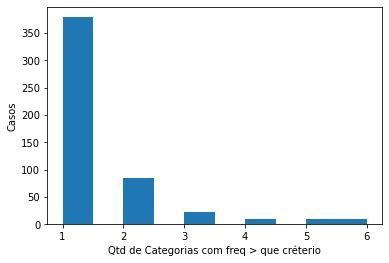

In [6]:
plt.hist(a['Categ'])  # density=False would make counts
plt.ylabel('Casos')
plt.xlabel('Qtd de Categorias com freq > que créterio');

In [7]:
a.sort_values('Categ',ascending= False).head(20)

,Palavra,Categ
406,size,6
501,with,6
35,and,6
303,new,6
86,by,6
34,amp,6
10,2,6
461,the,6
219,in,6
69,black,6


In [8]:
a2 = a[a.Categ>3 ].sort_values('Categ',ascending= False)
print(len(a2))
a2

29


,Palavra,Categ
10,2,6
501,with,6
34,amp,6
35,and,6
69,black,6
461,the,6
406,size,6
86,by,6
219,in,6
303,new,6


In [9]:
stop_words_fim = list(a[a.Categ>3]['Palavra'])

In [10]:
print(len(stop_words_fim))
stop_words_fim

29


['2',
 '3',
 '5',
 '6',
 'amp',
 'and',
 'black',
 'blue',
 'brown',
 'by',
 'color',
 'for',
 'green',
 'in',
 'large',
 'leather',
 'mens',
 'new',
 'of',
 'pack',
 'pink',
 'red',
 'set',
 'size',
 'the',
 'white',
 'with',
 'womens',
 'york']

## palavras q parecem  pouco

In [11]:
df_c = df_all.title_trat.str.split(expand=True).stack().value_counts().reset_index()
df_c.columns = ['Palavra', 'Freq'] 
total = len(df_cat)
df_c['Freq_%'] = df_c['Freq']/total
aux= df_c[df_c['Freq']< 20][['Palavra']]
print(len(aux))

128691


In [12]:
list3 = list(aux['Palavra'])

## somente numerico

In [13]:
len(list3)/total

2.8598

In [14]:
integers = [item for item in list_total if  item.isdigit()]
len(integers)

9841

## somente 2 char

In [15]:
char2 = [item for item in list_total if  len(item)<=2]
len(char2)

1054

In [16]:
stop_words_total = list(set(char2+integers+list3+stop_words_fim))
len(stop_words_total)

129351

In [17]:
lista_final = list(set(list_total) - set(stop_words_total))
len(lista_final)

8714

# Modelos

## Prepara

In [18]:
matrix = CountVectorizer(strip_accents  = 'unicode', lowercase  = True, vocabulary =lista_final, stop_words='english'
                         ,max_features= 10000)

In [19]:
df_all['Treino'] = np.where(np.random.randint(0,100, size=len(df_all))/100<=0.2,0,1)
df_all['Treino'].mean()

df_treino = df_all[df_all['Treino']==1]
print(len(df_treino))
df_teste = df_all[df_all['Treino']==0]
print(len(df_teste))

213555
56445


### Modelo Direto -> category_secondary

In [20]:
X_treino_i = matrix.fit_transform(df_treino['title'])
print(X_treino_i.shape[0])
Y_treino_i =  df_treino['category_secondary']
print(len(df_teste['title']))
X_teste_i = matrix.fit_transform(df_teste['title'])
print(X_teste_i.shape[0])
Y_teste_i =  df_teste['category_secondary']
#I =  df_all.index

palavras = matrix.get_feature_names()
print(len(palavras))

lista_cat = Y_treino_i.unique()
print(lista_cat)

213555
56445
56445
8714
['item_Clothing' 'item_Jewelry' 'item_Shoes' 'item_Sport_Clothing'
 'item_Accessories' 'item_Hunting']


In [21]:
i = 0 
lr_cat = []   
y_treino = []
y_teste = []
y_pred = []

for cat in lista_cat:

    print(str(i+1)+' - '+cat)

    y_treino.append(np.where(Y_treino_i == cat,1,0))
    y_teste.append(np.where(Y_teste_i == cat,1,0))

    lr_cat.append(LogisticRegression(fit_intercept = False, C=0.5,penalty='l1',solver='liblinear'))#, 'saga',‘liblinear’))
    lr_cat[i].fit(X_treino_i,y_treino[i])
    
 
    y_pred.append(lr_cat[i].predict_proba(X_teste_i)[:,1])
    
    print('      Acuracia: ' + "{0:.00%}".format(1 - mean(abs(y_pred[i] - y_teste[i])))) 
    
    i = i +1


1 - item_Clothing
      Acuracia: 91%
2 - item_Jewelry
      Acuracia: 97%
3 - item_Shoes
      Acuracia: 97%
4 - item_Sport_Clothing
      Acuracia: 90%
5 - item_Accessories
      Acuracia: 95%
6 - item_Hunting
      Acuracia: 97%


In [22]:
for i in range(5):
    print(lista_cat[i])
    mydf = pd.DataFrame(list(zip(list(matrix.get_feature_names()), list(lr_cat[i].coef_[0]))), columns = ['var', 'coef'])
    display(mydf.sort_values(by = 'coef', ascending = True).head(5))
    display(mydf.sort_values(by = 'coef', ascending = False).head(5))

item_Clothing


,var,coef
1992,sandal,-6.775988
155,pump,-6.427387
4505,earrings,-5.681600
6840,knife,-5.367147
5020,sneaker,-5.084037


,var,coef
1374,gown,4.126645
5085,jean,3.589658
5237,swimsuit,3.369717
516,bra,3.223727
5552,sarong,2.979359


item_Jewelry


,var,coef
6840,knife,-5.722936
7912,hanky,-5.680613
1960,shirt,-5.120501
5649,boot,-5.088753
3040,jacket,-4.721406


,var,coef
4505,earrings,7.579561
6761,cufflinks,5.633612
1234,jewelry,5.491683
5711,necklace,5.059045
6445,earring,5.051606


item_Shoes


,var,coef
1960,shirt,-6.998675
4505,earrings,-6.876314
2183,watch,-6.491075
5711,necklace,-6.246308
1512,shorts,-5.998507


,var,coef
5020,sneaker,6.537373
1992,sandal,6.049883
7193,clog,5.759845
3900,sandals,5.231541
8032,flop,4.993156


item_Sport_Clothing


,var,coef
6243,skinit,-7.289856
4505,earrings,-7.029006
6579,decal,-6.486036
324,wallet,-6.149504
6401,cgecko,-5.768958


,var,coef
7198,unitard,3.706070
5797,breech,3.628412
8590,spun,3.318203
3115,equine,3.129666
1389,amc,3.068976


item_Accessories


,var,coef
4505,earrings,-5.668739
1960,shirt,-5.572282
1992,sandal,-5.105587
3248,sweatshirt,-5.036002
6761,cufflinks,-4.857494


,var,coef
6401,cgecko,9.813471
1250,cue,5.062053
1230,referee,4.740950
6579,decal,4.721992
6705,treadmill,4.536380


In [23]:
mydf.sort_values(by = 'coef', ascending = False).head(5)

,var,coef
6401,cgecko,9.813471
1250,cue,5.062053
1230,referee,4.740950
6579,decal,4.721992
6705,treadmill,4.536380


In [24]:
i =0
for cat in lista_cat:
    df_teste[cat] = lr_cat[i].predict_proba(X_teste_i)[:,1]
    i = i +1

#### Resultado

In [25]:
df_teste['cat_pred1'] = df_teste[lista_cat].astype(float).idxmax(axis=1)
df_teste['acerto1'] = np.where(df_teste.category_secondary == df_teste.cat_pred1,1,0)
df_teste.groupby('category_secondary')['acerto1'].mean()

category_secondary
item_Accessories       0.920393
item_Clothing          0.821734
item_Hunting           0.944793
item_Jewelry           0.969342
item_Shoes             0.976542
item_Sport_Clothing    0.849255
Name: acerto1, dtype: float64

In [26]:
df_teste.head()

,title,category_main,category_secondary,title_trat,Treino,item_Clothing,item_Jewelry,item_Shoes,item_Sport_Clothing,item_Accessories,item_Hunting,cat_pred1,acerto1
784878,Carter's Baby Boy's 3 Piece Essentials,Clothing_Shoes_and_Jewelry,item_Clothing,carters baby boys 3 piece essentials,0,0.967636,0.006063,2.554375e-04,0.015595,0.010985,0.043002,item_Clothing,1
559963,"True Religion Women's Billy Straight Jean, Lon...",Clothing_Shoes_and_Jewelry,item_Clothing,true religion womens billy straight jean lones...,0,0.995756,0.005741,2.351659e-03,0.009562,0.001397,0.004665,item_Clothing,1
1286324,Jag Jeans Women's Mila Pull-On Straight Leg,Clothing_Shoes_and_Jewelry,item_Clothing,jag jeans womens mila pullon straight leg,0,0.961276,0.000107,5.420283e-03,0.020383,0.003685,0.000347,item_Clothing,1
1441852,WOMEN NEW PANT AFGANI COTTON YOGA GYPSY POCKET...,Clothing_Shoes_and_Jewelry,item_Clothing,women new pant afgani cotton yoga gypsy pocket...,0,0.517770,0.000010,3.133347e-07,0.363797,0.000228,0.000004,item_Clothing,1
797767,Bonnie Baby-girls Infant Leopard Print Fleece ...,Clothing_Shoes_and_Jewelry,item_Clothing,bonnie babygirls infant leopard print fleece l...,0,0.934168,0.000016,1.112036e-04,0.112352,0.000020,0.000007,item_Clothing,1


### Modelo duas etapas

#### Etapa 1

In [27]:
X_treino_i = matrix.fit_transform(df_treino['title'])
print(X_teste_i.shape[0])
Y_treino_i =  df_treino['category_main']
print(len(df_teste['title']))
X_teste_i = matrix.fit_transform(df_teste['title'])
print(X_teste_i.shape[0])
Y_teste_i =  df_teste['category_main']
#I =  df_all.index

palavras = matrix.get_feature_names()
print(len(palavras))

lista_cat = Y_treino_i.unique()
print(lista_cat)

56445
56445
56445
8714
['Clothing_Shoes_and_Jewelry' 'Sports_and_Outdoors']


In [28]:
i = 0 
lr_cat = []   
y_treino = []
y_teste = []
y_pred = []

for cat in lista_cat:

    print(str(i+1)+' - '+cat)

    y_treino.append(np.where(Y_treino_i == cat,1,0))
    y_teste.append(np.where(Y_teste_i == cat,1,0))

    lr_cat.append(LogisticRegression(fit_intercept = False, C=0.5,penalty='l1',solver='liblinear'))#, 'saga',‘liblinear’))
    lr_cat[i].fit(X_treino_i,y_treino[i])
    
    #print('Rodou modelo')   
 
    y_pred.append(lr_cat[i].predict_proba(X_teste_i)[:,1])
    
    print('      Acuracia: ' + "{0:.00%}".format(1 - mean(abs(y_pred[i] - y_teste[i])))) 
    
    i = i +1

    #print ('------------------------------------------')

1 - Clothing_Shoes_and_Jewelry
      Acuracia: 89%
2 - Sports_and_Outdoors
      Acuracia: 89%


In [29]:
i =0
for cat in lista_cat:
    df_teste[cat] = lr_cat[i].predict_proba(X_teste_i)[:,1]
    i = i +1

In [30]:
df_teste['cat_pred1'] = df_teste[lista_cat].astype(float).idxmax(axis=1)
df_teste['acerto1'] = np.where(df_teste.category_main == df_teste.cat_pred1,1,0)
df_teste.groupby('category_main')['acerto1'].mean()

category_main
Clothing_Shoes_and_Jewelry    0.924103
Sports_and_Outdoors           0.933373
Name: acerto1, dtype: float64

In [31]:
df_teste[df_teste.acerto1==0]['title']

75075                                    Thermax Mask - Mens
121541     Stylish Top with Peek-A-Boo Keyhole from Hot F...
826986            T Works Supima 3/4 Sleeve Crew - White - m
954877     The North Face Womens Pr Tka 100 Microvelour G...
1403155             Soffe Women's Zebra Crew Neck Sweatshirt
                                 ...                        
94459                       Final Approach Mutt Hut II Blind
130731                           (SP110060) 6'0&quot; 1 PC H
158446                             Simms HardBite Star Cleat
468346                                                PGKT05
244101                        Simms Freestone Boot - Size 13
Name: title, Length: 4022, dtype: object

In [32]:
for i in range(len(lista_cat)):
    print(lista_cat[i])
    mydf = pd.DataFrame(list(zip(list(matrix.get_feature_names()), list(lr_cat[i].coef_[0]))), columns = ['var', 'coef'])
    display(mydf.sort_values(by = 'coef', ascending = True).head(5))
    display(mydf.sort_values(by = 'coef', ascending = False).head(5))

Clothing_Shoes_and_Jewelry


,var,coef
6840,knife,-6.433944
1654,sight,-4.811121
8570,plano,-4.743145
7476,holster,-4.737426
4300,wading,-4.414903


,var,coef
4505,earrings,7.377857
6761,cufflinks,5.929035
5020,sneaker,5.862655
1992,sandal,5.343385
5711,necklace,5.001781


Sports_and_Outdoors


,var,coef
4505,earrings,-7.376135
6761,cufflinks,-5.929390
5020,sneaker,-5.864700
1992,sandal,-5.343415
5711,necklace,-4.999711


,var,coef
6840,knife,6.433507
1654,sight,4.810856
8570,plano,4.743358
7476,holster,4.737179
4300,wading,4.414520


#### Etapa 2 - categoria 1

In [33]:
df_treino_cat1 = df_treino[df_treino['category_main']=='Clothing_Shoes_and_Jewelry']
df_teste_cat1 = df_teste[df_teste['category_main']=='Clothing_Shoes_and_Jewelry']

X_treino_i = matrix.fit_transform(df_treino_cat1['title'])
print(X_teste_i.shape[0])
Y_treino_i =  df_treino_cat1['category_secondary']
print(len(df_teste_cat1['title']))
X_teste_i = matrix.fit_transform(df_teste_cat1['title'])
print(X_teste_i.shape[0])
Y_teste_i =  df_teste_cat1['category_secondary']
#I =  df_all.index

palavras = matrix.get_feature_names()
print(len(palavras))

lista_cat = Y_treino_i.unique()
print(lista_cat)

56445
28183
28183
8714
['item_Clothing' 'item_Jewelry' 'item_Shoes']


In [34]:
i = 0 
lr_cat1 = []   
y_treino = []
y_teste = []
y_pred = []

for cat in lista_cat:

    print(str(i+1)+' - '+cat)

    y_treino.append(np.where(Y_treino_i == cat,1,0))
    y_teste.append(np.where(Y_teste_i == cat,1,0))

    lr_cat1.append(LogisticRegression(fit_intercept = False, C=0.5,penalty='l1',solver='liblinear'))#, 'saga',‘liblinear’))
    lr_cat1[i].fit(X_treino_i,y_treino[i])
    
    #print('Rodou modelo')   
 
    y_pred.append(lr_cat1[i].predict_proba(X_teste_i)[:,1])
    
    print('      Acuracia: ' + "{0:.00%}".format(1 - mean(abs(y_pred[i] - y_teste[i])))) 
    
    i = i +1

    #print ('------------------------------------------')

1 - item_Clothing
      Acuracia: 97%
2 - item_Jewelry
      Acuracia: 98%
3 - item_Shoes
      Acuracia: 98%


In [35]:
i =0
X_teste_i = matrix.fit_transform(df_teste['title'])
for cat in lista_cat:
    df_teste[cat] = lr_cat1[i].predict_proba(X_teste_i)[:,1]
    i = i +1
    
lista_cat1 = lista_cat

In [36]:
df_teste['cat_pred2_cat1'] = df_teste[lista_cat].astype(float).idxmax(axis=1)
df_teste['acerto2_cat1'] = np.where(df_teste.category_secondary == df_teste.cat_pred2_cat1,1,0)
df_teste.groupby('category_secondary')['acerto2_cat1'].mean()

category_secondary
item_Accessories       0.000000
item_Clothing          0.979078
item_Hunting           0.000000
item_Jewelry           0.991803
item_Shoes             0.984290
item_Sport_Clothing    0.000000
Name: acerto2_cat1, dtype: float64

In [37]:
for i in range(len(lista_cat)):
    print(lista_cat[i])
    mydf = pd.DataFrame(list(zip(list(matrix.get_feature_names()), list(lr_cat1[i].coef_[0]))), columns = ['var', 'coef'])
    display(mydf.sort_values(by = 'coef', ascending = True).head(5))
    display(mydf.sort_values(by = 'coef', ascending = False).head(5))

item_Clothing


,var,coef
1992,sandal,-7.336023
155,pump,-7.123952
4505,earrings,-6.386924
5020,sneaker,-6.018714
7193,clog,-5.850106


,var,coef
1512,shorts,6.122742
5197,pant,5.287239
1960,shirt,5.206001
5069,tee,5.202492
5085,jean,5.037177


item_Jewelry


,var,coef
5208,satchel,-4.953636
5649,boot,-4.797892
1960,shirt,-4.535490
3040,jacket,-4.508571
5681,hobo,-4.413881


,var,coef
4505,earrings,7.399312
2183,watch,7.139663
2921,bracelet,6.281567
5711,necklace,5.280940
5798,ring,5.144433


item_Shoes


,var,coef
5933,clips,-7.427112
4505,earrings,-7.384212
5711,necklace,-7.037166
1960,shirt,-6.741720
2183,watch,-5.781684


,var,coef
1992,sandal,6.740975
3286,sneakers,6.340676
5020,sneaker,6.140310
155,pump,6.048388
3900,sandals,5.886401


#### Etapa 2 - categoria 2

In [38]:
df_treino_cat2 = df_treino[df_treino['category_main']=='Sports_and_Outdoors']
df_teste_cat2 = df_teste[df_teste['category_main']=='Sports_and_Outdoors']

X_treino_i = matrix.fit_transform(df_treino_cat2['title'])
print(X_teste_i.shape[0])
Y_treino_i =  df_treino_cat2['category_secondary']
print(len(df_treino_cat2['title']))
X_teste_i = matrix.fit_transform(df_treino_cat2['title'])
print(X_teste_i.shape[0])
Y_teste_i =  df_treino_cat2['category_secondary']
#I =  df_all.index

palavras = matrix.get_feature_names()
print(len(palavras))

lista_cat = Y_treino_i.unique()
print(lista_cat)

56445
106738
106738
8714
['item_Sport_Clothing' 'item_Accessories' 'item_Hunting']


In [39]:
i = 0 
lr_cat2 = []   
y_treino = []
y_teste = []
y_pred = []

for cat in lista_cat:

    print(str(i+1)+' - '+cat)

    y_treino.append(np.where(Y_treino_i == cat,1,0))
    y_teste.append(np.where(Y_teste_i == cat,1,0))

    lr_cat2.append(LogisticRegression(fit_intercept = False, C=0.5,penalty='l1',solver='liblinear'))#, 'saga',‘liblinear’))
    lr_cat2[i].fit(X_treino_i,y_treino[i])
    
    #print('Rodou modelo')   
 
    y_pred.append(lr_cat2[i].predict_proba(X_teste_i)[:,1])
    
    print('      Acuracia: ' + "{0:.00%}".format(1 - mean(abs(y_pred[i] - y_teste[i])))) 
    
    i = i +1

    #print ('------------------------------------------')

1 - item_Sport_Clothing
      Acuracia: 95%
2 - item_Accessories
      Acuracia: 93%
3 - item_Hunting
      Acuracia: 95%


In [40]:
i =0
X_teste_i = matrix.fit_transform(df_teste['title'])
for cat in lista_cat:
    df_teste[cat] = lr_cat2[i].predict_proba(X_teste_i)[:,1]
    i = i +1
    

In [41]:
df_teste['cat_pred2_cat2'] = df_teste[lista_cat].astype(float).idxmax(axis=1)
df_teste['acerto2_cat2'] = np.where(df_teste.category_secondary == df_teste.cat_pred2_cat2,1,0)
df_teste.groupby('category_secondary')['acerto2_cat2'].mean()

category_secondary
item_Accessories       0.945790
item_Clothing          0.000000
item_Hunting           0.950439
item_Jewelry           0.000000
item_Shoes             0.000000
item_Sport_Clothing    0.976627
Name: acerto2_cat2, dtype: float64

In [42]:
for i in range(len(lista_cat)):
    print(lista_cat[i])
    mydf = pd.DataFrame(list(zip(list(matrix.get_feature_names()), list(lr_cat2[i].coef_[0]))), columns = ['var', 'coef'])
    display(mydf.sort_values(by = 'coef', ascending = True).head(5))
    display(mydf.sort_values(by = 'coef', ascending = False).head(5))

item_Sport_Clothing


,var,coef
6401,cgecko,-10.641133
3121,moda,-7.464258
2183,watch,-6.013881
7476,holster,-5.494253
6243,skinit,-4.954373


,var,coef
3248,sweatshirt,4.557114
1960,shirt,4.340422
2436,socks,4.101106
5043,jersey,3.916238
2073,leotard,3.894801


item_Accessories


,var,coef
1960,shirt,-5.415745
7476,holster,-5.295175
3248,sweatshirt,-5.061546
5197,pant,-4.436197
6840,knife,-4.329770


,var,coef
6401,cgecko,9.444451
3121,moda,7.607949
2183,watch,6.087452
1230,referee,5.190826
6579,decal,4.463944


item_Hunting


,var,coef
5043,jersey,-5.433844
1512,shorts,-5.082437
7010,trampoline,-4.547059
4587,pedometer,-4.439543
1250,cue,-4.298297


,var,coef
7476,holster,5.366142
1066,concealment,5.054055
528,wader,4.303696
2675,rcbs,4.256717
6583,fishing,4.204157


#### Etapa 2 - JUnta

In [43]:
df_teste_sumup = df_teste[['category_main', 'category_secondary'
        , 'cat_pred1', 'acerto1'
        , 'cat_pred2_cat1', 'acerto2_cat1'
          , 'cat_pred2_cat2', 'acerto2_cat2']]

df_teste_sumup['cat_pred2_fim'] = np.where(df_teste_sumup.cat_pred1 == 'Clothing_Shoes_and_Jewelry',df_teste_sumup.cat_pred2_cat1,df_teste_sumup.cat_pred2_cat2)
df_teste_sumup['acerto2_fim'] = np.where(df_teste_sumup.category_secondary == df_teste_sumup.cat_pred2_fim,1,0)
df_teste_sumup.groupby('category_secondary')['acerto2_fim'].mean()

category_secondary
item_Accessories       0.916764
item_Clothing          0.804974
item_Hunting           0.939356
item_Jewelry           0.962103
item_Shoes             0.971341
item_Sport_Clothing    0.839284
Name: acerto2_fim, dtype: float64